## School project - 5DEEP
The following notebook has been created for a school project on audio classification. The subject and the questions are available in the appendix.

The group members who participated in this project are:
- BEZIN Théo
- LAMINE AMIMI Mohamed
- LECOMTE Alexis
- PAWLOWSKI Maxence

### Main index
1. Data analysis
2. Data preprocessing
3. **Basic ANN model (you are here)**
4. The CNN model
5. Testing our best model

# 3 - Basic ANN model
Now that the dataset is converted into an array of Mel spectrograms, we can begin training our model with a simple Artificial Neural Network (ANN). ANNs are inspired by the biological neural networks that make up animal brains. These neurons are aggregated in layers, each of them performing different transformations on their inputs. Signals (the data) travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times.

### Index
<ol type="A">
  <li>Notebook initialization</li>
  <li>Data preparation</li>
  <li>First model: Artificial Neural Network (ANN)</li>
  <li>Evaluating the model</li>
  <li>Conclusion of the ANN model</li>
</ol>

## A - Notebook initialization
### A.1 - Imports

In [25]:
# OS and filesystem
from pathlib import Path
from timeit import default_timer as timer
from datetime import timedelta

# Math
import numpy

# Data
import re
import pandas
from matplotlib import pyplot

# Sound processing
import librosa
import librosa.display

# Model processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics
import tensorflow
from tensorflow import keras

# Console output
from colorama import Fore, Style
from tqdm.notebook import tqdm

# Jupyter output
import IPython.display

### A.2 - Package initialization

In [3]:
pyplot.style.use("ggplot")  # Set the matplotlib style

### A.3 - Constants

In [4]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = (PARENT_FOLDER / ".." / ".." / "data").resolve()
URBAN_DATASET_FOLDER = DATA_FOLDER / "UrbanSound8K"
MODELS_FOLDER = (PARENT_FOLDER / ".." / ".." / "models").resolve()
TEMP_FOLDER = (PARENT_FOLDER / ".." / ".." / "temp").resolve()

# Dataset
CLASSES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

# Misc.
RANDOM_STATE = 2077

### A.4 - Utilities

In [5]:
def get_full_path(fold: int, file_name: str) -> Path:
    return URBAN_DATASET_FOLDER / "audio" / f"fold{fold}" / file_name


def load_audio(fold: int, file_name: str, mono: bool = True, sampling_rate: int | None = 22050) -> tuple[numpy.ndarray, int]:
    file_path = get_full_path(fold=fold, file_name=file_name)
    samples, sr = librosa.load(file_path, mono=mono, sr=sampling_rate)

    return samples, sr

### A.5 - Dataset loading

In [6]:
features_x = numpy.load(file=(str(DATA_FOLDER / "x-mel-spectrograms_13-02-23_14-44.npy")))
features_y = numpy.load(file=(str(DATA_FOLDER / "y-mel-spectrograms_13-02-23_14-44.npy")))

Since the model is a simple neural network, the input cannot be a 2D array (an image). We average by frequencies over time to flatten the data array.

In [7]:
features_x = numpy.mean(features_x, axis=1)

## B - Data preparation
Our dataset is almost ready. We still need to encode the labels and split this dataset into a training and test set.

### B.1 - Label encoding
The neural network cannot interpret a string such as class names, we need to encode it. There are two options: one-hot encoding and label encoding.

Label encoding is a technique for handling categorical variables. In this technique, each label is assigned a unique integer number based on alphabetical order. The main problem with this technique is that it creates a kind of ranking between categories. The model might interpret a higher integer as a better value. This type of encoding works well with ordinal features or when there are a large number of categories.

One-hot encoding is another technique for transforming categorical variables. It creates additional features (columns in the case of a dataframe) based on the number of unique values in the categorical features. Each possible value is represented by a new feature with two possible values: 0 or 1. This technique solves the label encoding problem, but it creates another one. We must be careful not to fall into the *dummy variable trap*. A *dummy variable trap* occurs when two categories have a very high correlation. For example, "single" and "divorced" are very close and the model could interpret these two categories as being the same, but in fact they are very different. In contrast to label encoding, one-hot encoding performs better on non-ordinal features and when the number of categories remains low.

In our case, we have only ten different classes, and they are not ordinal. One-hot encoding seems to be the best technique for our dataset. However, we might have a problem with two of the classes. The classes `jackhammer` and `drilling` can be perceived as quite close, so they might have a strong correlation. We have to be careful not to fall into the *dummy variable trap* explained above.

In [8]:
label_encoder = LabelEncoder()
features_y = keras.utils.to_categorical(y=label_encoder.fit_transform(features_y), num_classes=len(CLASSES))

### B.2 - Dataset splitting
The final step in data preparation is to divide the data set into a training and test set.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(features_x, features_y, test_size=0.2, random_state=RANDOM_STATE)

print(f"{Style.BRIGHT}Train set >{Style.RESET_ALL} rows: (x={len(x_train)}, y={len(y_train)}) | shape: (x={x_train.shape}, y={y_train.shape})")
print(f"{Style.BRIGHT}Test set >{Style.RESET_ALL} rows: (x={len(x_test)}, y={len(y_test)}) | shape: (x={x_test.shape}, y={y_test.shape})")

Train set > rows: (x=6985, y=6985) | shape: (x=(6985, 173), y=(6985, 10))
Test set > rows: (x=1747, y=1747) | shape: (x=(1747, 173), y=(1747, 10))


## C - First model: Artificial Neural Network (ANN)
### C.1 - Model architecture
We will use the [Sequential](https://keras.io/guides/sequential_model/) model API from the `keras` package to build our ANN. The [Sequential](https://keras.io/guides/sequential_model/) API is a very simple and straightforward way to create a model, but it is limited to single-input, single-output stacks of layer. However, this limitation is not a problem for our use case.

1. All layers are a [Dense](https://keras.io/api/layers/core_layers/dense/) layer, a regular neural network layer with dense connections. The input shape of this layer is $(batchSize, inputDim)$ and the output shape is $(batchSize, units)$. Each layer will produce a slightly smaller output than the previous one.
2. The activation function used in all layers except the last one is the [relu (rectified linear unit)](https://keras.io/api/layers/activations/#relu-function) function. The last layer uses the [softmax](https://keras.io/api/layers/activations/#softmax-function) activation function to convert the vector of values from the penultimate layer into a probability distribution.

### C.2 - Model definition

Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1000)              174000    
                                                                 
 dense_8 (Dense)             (None, 750)               750750    
                                                                 
 dense_9 (Dense)             (None, 500)               375500    
                                                                 
 dense_10 (Dense)            (None, 250)               125250    
                                                                 
 dense_11 (Dense)            (None, 100)               25100     
                                                                 
 dense_12 (Dense)            (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 10)                510     

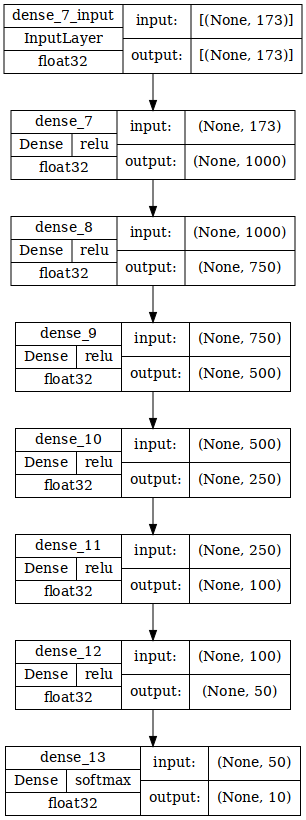

In [16]:
# Model definition
model_ann = keras.models.Sequential(name="ANN", layers=[
    keras.layers.Dense(1000, activation="relu", input_shape=(x_train.shape[1],)),
    keras.layers.Dense(750, activation="relu"),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(len(CLASSES), activation="softmax")
])

# Model summary and plot
model_ann.summary()
keras.utils.plot_model(
    model_ann,
    show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True,
    rankdir="TB", dpi=72,
    to_file=(TEMP_FOLDER / "model_plot_ann.png")
)

### C.3 - Model optimizer and loss function
We use the [ADAM](https://keras.io/api/optimizers/adam/) optimizer because it has very good performance, often better the more iterations the model has. The loss function used is the [categorical crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) because it is a multi-class classification model.

In [17]:
adam_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_ann.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])

### C.4 - Model callbacks
A callback is an object that can perform actions at various stages of training. We use the [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) to regularly save our model to the disk.

In [18]:
# Model checkpoint to save the model to the disk
ckpt_name_base = "1_model-ann-ckpt"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=str(MODELS_FOLDER / f"{ckpt_name_base}_e-{{epoch:02d}}_vloss-{{val_loss:.2f}}.hdf5"),
    monitor="val_loss",
    save_best_only=True,
    verbose=0
)

### C.5 - Model training

In [19]:
batch_size = 128
epochs = 200

start_time = timer()
training_ann = model_ann.fit(x=x_train, y=y_train, validation_split=0.080, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_callback], verbose=1)
print(f"The training of the \"{model_ann.name}\" model took {timedelta(seconds=(timer() - start_time))}.")

Epoch 1/200
51/51 [==============================] - 1s 11ms/step - loss: 2.1347 - accuracy: 0.2149 - val_loss: 1.9931 - val_accuracy: 0.2630
Epoch 2/200
51/51 [==============================] - 0s 9ms/step - loss: 1.9035 - accuracy: 0.2852 - val_loss: 1.8298 - val_accuracy: 0.3005
Epoch 3/200
51/51 [==============================] - 0s 8ms/step - loss: 1.7623 - accuracy: 0.3240 - val_loss: 1.7372 - val_accuracy: 0.3596
Epoch 4/200
51/51 [==============================] - 0s 9ms/step - loss: 1.6906 - accuracy: 0.3627 - val_loss: 1.7324 - val_accuracy: 0.3453
Epoch 5/200
51/51 [==============================] - 0s 7ms/step - loss: 1.6584 - accuracy: 0.3771 - val_loss: 1.7922 - val_accuracy: 0.3345
Epoch 6/200
51/51 [==============================] - 0s 9ms/step - loss: 1.6279 - accuracy: 0.3858 - val_loss: 1.6850 - val_accuracy: 0.3542
Epoch 7/200
51/51 [==============================] - 0s 8ms/step - loss: 1.5701 - accuracy: 0.4115 - val_loss: 1.6989 - val_accuracy: 0.3453
Epoch 8/200


### C.6 - Loading the best model
We load the checkpoint with the lowest validation loss. This model may not be the most accurate, but it is not over-fitted for its dataset.

In [44]:
def load_best_model(base_name: str, loss_key: str = "vloss-") -> keras.Model:
    # Get all the checkpoints
    ckpt_files = [file for file in MODELS_FOLDER.glob(f"{base_name}*.hdf5") if file.is_file()]
    lowest_loss = None
    best_ckpt = ckpt_files[0]

    # Find the checkpoint with the lower validation loss
    for file in ckpt_files:
        val_loss = re.search(pattern=fr"{loss_key}[-+]?(?P<loss_value>\d*\.*\d+)", string=file.name)

        if val_loss:
            val_loss = float(val_loss.group("loss_value"))

            if (lowest_loss is None) or (val_loss <= lowest_loss):
                lowest_loss = val_loss
                best_ckpt = file

    # Load the best model
    return keras.models.load_model(filepath=best_ckpt, compile=True)


best_model = load_best_model(base_name=ckpt_name_base)

## D - Evaluating the model
We define various functions that will help us visualize the performance of our model.

In [79]:
def print_model_metrics(model: keras.Model, x_train: numpy.ndarray, y_train: numpy.ndarray, x_test: numpy.ndarray, y_test: numpy.ndarray) -> None:
    # Model metrics
    train_loss, train_acc = model.evaluate(x=x_train, y=y_train, verbose=0)
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)

    print(f"{Style.BRIGHT}Model metrics:{Style.RESET_ALL}")
    print(f"{Style.BRIGHT}Training >{Style.RESET_ALL} loss={train_loss:.3f} | accuracy={(train_acc * 100):.3f}")
    print(f"{Style.BRIGHT}Testing >{Style.RESET_ALL} loss={test_loss:.3f} | accuracy={(test_acc * 100):.3f}")


def print_classification_report(model: keras.Model, x_test: numpy.ndarray, y_test: numpy.ndarray, le: LabelEncoder) -> None:
    y_pred_one_hot = model.predict(x_test, verbose=0)  # From one-hot encoded labels ...
    y_pred_labels = numpy.argmax(y_pred_one_hot, axis=1)  # ... to label encoding
    y_test_labels = numpy.argmax(y_test, axis=1)  # Same for the true labels

    print(sklearn.metrics.classification_report(
        y_true=y_test_labels,
        y_pred=y_pred_labels,
        target_names=le.inverse_transform(numpy.arange(len(CLASSES)))
    ))


def plot_loss_curve(history: dict) -> None:
    # Get the minimum loss value
    min_loss = min(history["loss"])
    min_loss_epoch = history["loss"].index(min_loss)

    min_val_loss = min(history["val_loss"])
    min_val_loss_epoch = history["val_loss"].index(min_val_loss)

    # Plot
    pyplot.figure(figsize=(12, 4))
    loss_curve, = pyplot.plot(history["loss"])  # Loss curve
    val_loss_curve, = pyplot.plot(history["val_loss"], linestyle="--")  # Validation loss curve
    min_loss_point, = pyplot.plot(min_loss_epoch, min_loss, marker="o", markersize=4)  # Plot a point at the minimum loss value
    min_val_loss_point, = pyplot.plot(min_val_loss_epoch, min_val_loss, marker="o", markersize=4)  # Plot a point at the minimum validation loss value

    pyplot.title("Loss per epochs")
    pyplot.xticks(numpy.arange(start=0, stop=len(history["loss"]), step=5), rotation=90)
    pyplot.xlabel("Epoch")
    pyplot.ylabel("Loss")
    pyplot.legend(
        handles=[loss_curve, val_loss_curve, min_loss_point, min_val_loss_point],
        labels=["Train", "Validation", f"{min_loss:.3f}", f"{min_val_loss:.3f}"]
    )
    pyplot.show()


def plot_accuracy_curve(history: dict) -> None:
    # Get the maximum accuracy value
    max_acc = max(history["accuracy"])
    max_acc_epoch = history["accuracy"].index(max_acc)

    max_val_acc = max(history["val_accuracy"])
    max_val_acc_epoch = history["val_accuracy"].index(max_val_acc)

    # Plot
    pyplot.figure(figsize=(12, 4))
    acc_curve, = pyplot.plot(history["accuracy"])  # Accuracy curve
    val_acc_curve, = pyplot.plot(history["val_accuracy"], linestyle="--")  # Validation accuracy curve
    max_acc_point, = pyplot.plot(max_acc_epoch, max_acc, marker="o", markersize=4)  # Plot a point at the maximum accuracy value
    max_val_acc_point, = pyplot.plot(max_val_acc_epoch, max_val_acc, marker="o", markersize=4)  # Plot a point at the maximum validation accuracy value

    pyplot.title("Accuracy per epochs")
    pyplot.xticks(numpy.arange(start=0, stop=len(history["accuracy"]), step=5), rotation=90)
    pyplot.xlabel("Epoch")
    pyplot.ylabel("Accuracy")
    pyplot.legend(
        handles=[acc_curve, val_acc_curve, max_acc_point, max_val_acc_point],
        labels=["Train", "Validation", f"{max_acc:.3f}", f"{max_val_acc:.3f}"]
    )
    pyplot.show()


def plot_confusion_matrix(model: keras.Model, x_test: numpy.ndarray, y_test: numpy.ndarray) -> None:
    y_pred_one_hot = model.predict(x_test, verbose=0)  # From one-hot encoded labels ...
    y_pred_labels = numpy.argmax(y_pred_one_hot, axis=1)  # ... to label encoding
    y_test_labels = numpy.argmax(y_test, axis=1)  # Same for the true labels
    matrix = sklearn.metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

    # Plot the confusion matrix
    matrix_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=label_encoder.classes_)
    matrix_plot.plot(cmap="plasma")
    pyplot.xticks(rotation=90)
    pyplot.grid(visible=False)
    pyplot.show()

    # Print the performance per class
    accuracies_per_class = []

    for index in range(0, matrix.shape[0]):
        correct_predictions = matrix[index][index].astype(int)
        total_predictions = matrix[index].sum().astype(int)
        accuracies_per_class.append(f"{round(((correct_predictions / total_predictions) * 100), 2)} %")

    print(pandas.DataFrame(data={"Class": CLASSES, "Accuracy": accuracies_per_class}))


### D.1 - Accuracy and loss
Accuracy is a measure of the quality of the model predictions. The model predictions are compared to the true values in the dataset.

The loss is a value that represents the sum of the errors of our model. It measures the efficiency of our model. If the errors are large, the loss will be high, which means that the model is not doing a good job. The lower it is, the better our model works.

A high loss means that there are large errors in the model predictions, a low accuracy means that there are many errors.

In [64]:
print_model_metrics(model=best_model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Model metrics:
Training > loss=1.563 | accuracy=40.888
Testing > loss=1.693 | accuracy=35.031


The best model was selected based on the value of the loss. This means that no other ANN model, more or less trained, was better than this one.

The loss value between the training and test sets is almost the same. Our model neither over-fits nor under-fits the dataset. But, even with a good loss score, the accuracy of the model is pretty bad. It doesn't make big mistakes, but it often does.

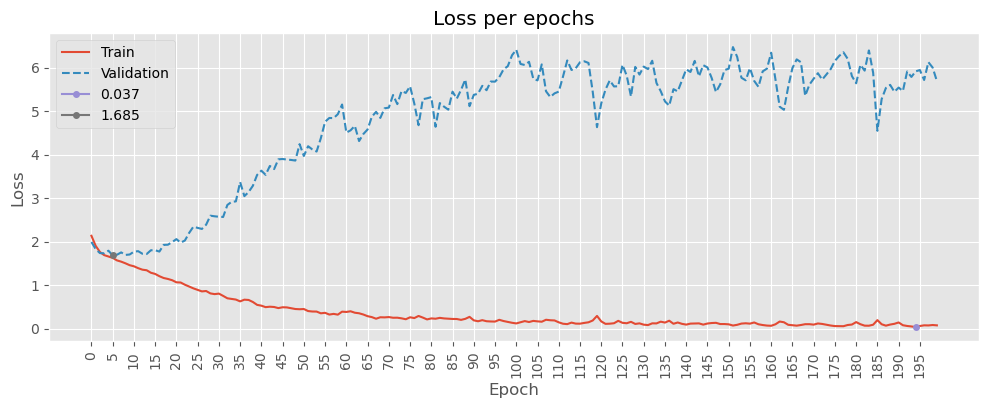

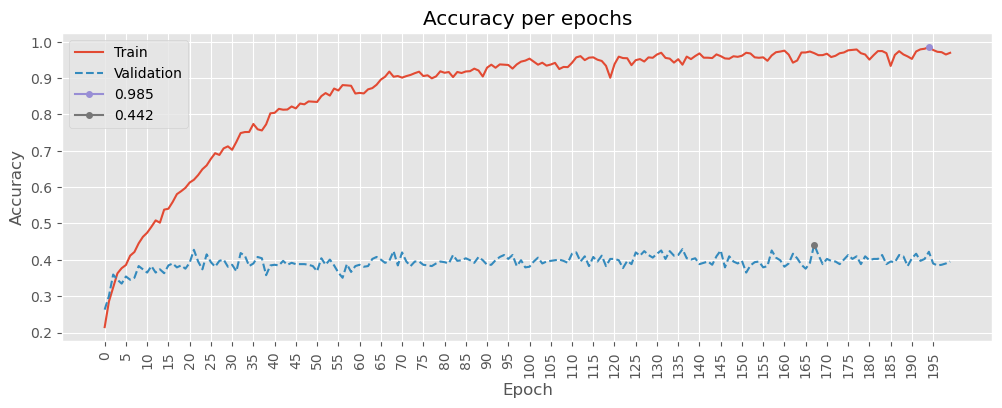

In [65]:
plot_loss_curve(history=training_ann.history)
plot_accuracy_curve(history=training_ann.history)

We can see with the following graphs that the model tends to over-fit very quickly, around the 12th epoch.

### D.2 - Confusion matrix

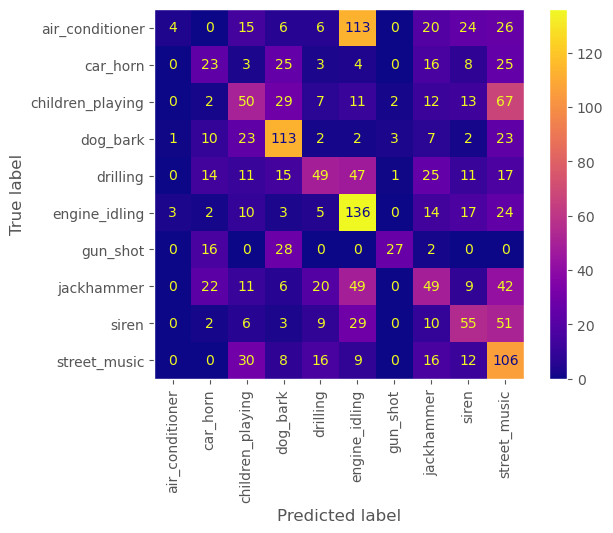

              Class Accuracy
0   air_conditioner   1.87 %
1          car_horn   21.5 %
2  children_playing  25.91 %
3          dog_bark  60.75 %
4          drilling  25.79 %
5     engine_idling  63.55 %
6          gun_shot  36.99 %
7        jackhammer  23.56 %
8             siren  33.33 %
9      street_music  53.81 %


In [76]:
plot_confusion_matrix(model=best_model, x_test=x_test, y_test=y_test)

The confusion matrix makes it easier to visualize the errors in our model. We can see huge prediction errors between some classes such as `air_conditioner` with `engine_idling` and `children_playing` with `street_music`.

### D.3 - Classification report

In [80]:
print_classification_report(model=best_model, x_test=x_test, y_test=y_test, le=label_encoder)

                  precision    recall  f1-score   support

 air_conditioner       0.50      0.02      0.04       214
        car_horn       0.25      0.21      0.23       107
children_playing       0.31      0.26      0.28       193
        dog_bark       0.48      0.61      0.54       186
        drilling       0.42      0.26      0.32       190
   engine_idling       0.34      0.64      0.44       214
        gun_shot       0.82      0.37      0.51        73
      jackhammer       0.29      0.24      0.26       208
           siren       0.36      0.33      0.35       165
    street_music       0.28      0.54      0.37       197

        accuracy                           0.35      1747
       macro avg       0.41      0.35      0.33      1747
    weighted avg       0.38      0.35      0.32      1747



As expected, the class `air conditioner` gets the worst recall score. We saw earlier on the confusion matrix that this class is largely confused with the class `engine_idling`. But the opposite is not true, the class `engine_idling` is not confused with the class `air_conditioner` and even gets the best recall score.

## E - Conclusion of the ANN model
The performance graphs showed us that this Artificial Neural Network model gets a terribly low classification score. This is mainly due to the fact that a densely-connected model takes a two-dimensional array as input with $(batchSize,inputDim)$. The input data must therefore be a one-directional array, which forces us to average the Mel spectrogram. Averaging results in a loss of data, thus a loss of score.

In the next notebook, we will perform almost the same experiment but this time using a CNN model.